In [134]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


# Import Data

In [152]:
import pandas as pd
import numpy as np

# Convert Data from JSON to Pandas
reviews = pd.read_json('yelp_academic_dataset_review.json', lines=True, nrows=15000)
reviews = reviews.rename(columns={'stars': 'review_rating'})


businesses = pd.read_json('yelp_academic_dataset_business.json', lines=True, nrows=15000)
businesses = businesses.rename(columns={'stars': 'business_rating'})


# Keep all business with more than 20 lines & merge the reviews

In [153]:

# Remove all business with reivew count < 20
print("removed businesses: ", businesses[businesses.review_count < 20].shape[0])
businesses =  businesses[businesses.review_count > 20]

all_reviews = pd.merge(businesses,reviews, on='business_id') 

removed businesses:  8741


# Get all reviews for one business

In [154]:
# print("Individual Reviews (after join): ", all_reviews.shape)

all_reviews = all_reviews[['business_id', 'text', 'business_rating']]
# print(all_reviews.head())

reviews_agg = all_reviews.groupby('business_id')['text'].sum()
rating_avg = all_reviews.groupby('business_id')['business_rating'].mean()

df_reviews_agg = pd.DataFrame({'business_id': reviews_agg.index, 'all_reviews': reviews_agg.values})
df_rating_avg = pd.DataFrame({'business_id': rating_avg.index, 'business_rating': rating_avg.values})

df_agg = pd.merge(df_reviews_agg, df_rating_avg, on='business_id')
df_agg.head()
# print(df_reviews_agg)


,business_id,all_reviews,business_rating
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,4.5
1,-02xFuruu85XmDn2xiynJw,Dr. Curtis Dechant has an excellent chair-side...,4.5
2,-1MhPXk1FglglUAmuPLIGg,Great food and drink. The staff are always fri...,4.0
3,-1ueCbvIpUPi8KT95ETTKw,I was very happy here.there is a shower with a...,4.0
4,-2Axhv9AZ_n7qjQefECpVw,"The service was excellent, extremely friendly....",3.5


In [155]:
# df_reviews_agg[df_reviews_agg.isnull().any(axis=1)].shape
df_agg['all_reviews'].shape


(3623,)

# TF_IDF Vectorizer

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=500,min_df=1)
# Fit and transform the aggregated reviews into a TF-IDF matrix
tfidf_wm = vectorizer.fit_transform(df_agg['all_reviews'])

# Retrieve the feature names (i.e., the vocabulary)
tfidf_tokens = vectorizer.get_feature_names_out()

# Create a DataFrame from the TF-IDF matrix for easier viewing
df_tfidfvect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

df_tfidfvect


,10,12,15,20,30,50,able,absolutely,actually,add,...,worst,worth,wouldn,wow,wrong,year,years,yelp,yes,yummy
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,0.000000,0.122862,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.054658,0.0,0.0,0.055361,0.000000,0.109635,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3618,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.166341,0.000000,0.0,0.0
3619,0.000000,0.000000,0.233246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.123377,0.092485,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
3620,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
3621,0.042707,0.058067,0.051030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.040468,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


# Create one table with all information

In [157]:
# business_id, rating concatonated onto the df_idfvect
df_business = pd.concat([df_agg[['business_id', 'business_rating']], df_tfidfvect], axis=1)

# Test/Train Split

In [158]:
encode_text_index(df_business, 'business_id')
missing_median(df_business, 'business_rating')

df_business
df_business_new = df_business.copy()

x, y = to_xy(df_business_new, 'business_rating')

In [159]:
from sklearn.model_selection import train_test_split

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)


Epoch 1/1000
91/91 - 1s - loss: 3.4216 - val_loss: 0.5741 - 1s/epoch - 16ms/step
Epoch 2/1000
91/91 - 0s - loss: 0.5657 - val_loss: 0.5848 - 217ms/epoch - 2ms/step
Epoch 3/1000
91/91 - 0s - loss: 0.5669 - val_loss: 0.5753 - 236ms/epoch - 3ms/step
Epoch 4/1000
91/91 - 0s - loss: 0.5661 - val_loss: 0.5707 - 217ms/epoch - 2ms/step
Epoch 5/1000
91/91 - 0s - loss: 0.5673 - val_loss: 0.5739 - 214ms/epoch - 2ms/step
Epoch 6/1000
91/91 - 0s - loss: 0.5681 - val_loss: 0.5708 - 212ms/epoch - 2ms/step
Epoch 7/1000
91/91 - 0s - loss: 0.5672 - val_loss: 0.5720 - 219ms/epoch - 2ms/step
Epoch 8/1000
91/91 - 0s - loss: 0.5670 - val_loss: 0.5721 - 215ms/epoch - 2ms/step
Epoch 9/1000
91/91 - 0s - loss: 0.5667 - val_loss: 0.5727 - 235ms/epoch - 3ms/step
Epoch 9: early stopping
23/23 [==============================] - 0s 2ms/step
Score (RMSE): 0.7567396759986877


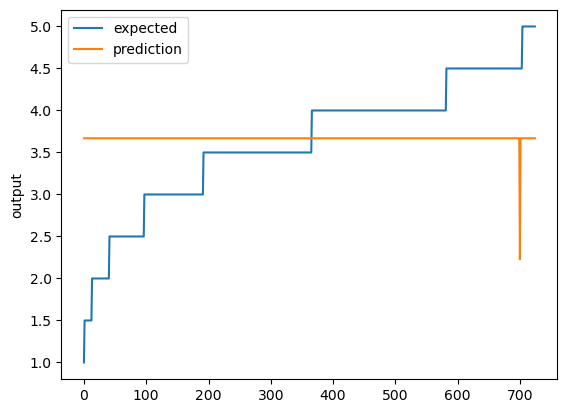

In [160]:
# Model #1 : (decide # of neurons in hiddens layers, relu, adam)
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam



# Create the model
input_shape = x.shape[1]
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='tanh')) #changed to 100
model.add(Dense(50, input_dim=x.shape[1], activation='relu')) #changed to 100

# maybe try this to see 
model.add(Dropout(0.5)) 
model.add(Dense(1))

# much smaller lr
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
sgd = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)   
model.compile(loss='mean_squared_error', optimizer=sgd)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
# heckpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor],verbose=2,epochs=1000)
# model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)
